## Notebook to create figures with APGB meta data
Sources:
 - https://gis.stackexchange.com/questions/411376/wfs-layer-saved-as-a-shapefile
 - https://pcjericks.github.io/py-gdalogr-cookbook/vector_layers.html#get-wfs-layers-and-iterate-over-features
 

In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
from osgeo import ogr, osr, gdal
import geopandas as gpd
import sys
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
sys.path.append('../scripts/')
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
path_dict = loadpaths.loadpaths()

In [3]:
df_tile_outlines = lca.load_pols(path_dict['landscape_character_grid_path'])
df_pd_outline = lca.load_pols(path_dict['pd_outline'])
## only keep tiles that intersect with pd _outline 
df_tile_outlines = df_tile_outlines[df_tile_outlines.intersects(df_pd_outline.unary_union)]
df_tile_outlines = df_tile_outlines.reset_index(drop=True)
assert len(df_tile_outlines) == 1617
arr_tile_names = df_tile_outlines['PLAN_NO'].values


In [4]:
# 'SE0d503' in arr_tile_names

In [5]:
url = 'https://ogc.apps.midgard.airbusds-cint.com/apgb/wfs?service=WFS&guid=4cd2b5e0-41fd-41e1-90a8-09c2fb51cbf6&request=GetCapabilities'

In [6]:
# Set the driver (optional)
wfs_drv = ogr.GetDriverByName('WFS')

# Speeds up querying WFS capabilities for services with alot of layers
gdal.SetConfigOption('OGR_WFS_LOAD_MULTIPLE_LAYER_DEFN', 'NO')

# Set config for paging. Works on WFS 2.0 services and WFS 1.0 and 1.1 with some other services.
gdal.SetConfigOption('OGR_WFS_PAGING_ALLOWED', 'YES')
gdal.SetConfigOption('OGR_WFS_PAGE_SIZE', '10000')

# Open the webservice
# url = 'http://example-service.com/wfs'
wfs_ds = wfs_drv.Open('WFS:' + url)

In [7]:
if False:
    ## Get info of all layers

    # iterate over available layers
    for i in range(wfs_ds.GetLayerCount()):
        layer = wfs_ds.GetLayerByIndex(i)
        srs = layer.GetSpatialRef()
        print('Layer: %s, Features: %s, SR: %s...' % (layer.GetName(), layer.GetFeatureCount(), srs.ExportToWkt()[0:50]))


In [8]:
## Select layer:
layer = wfs_ds.GetLayerByIndex(3)
srs = layer.GetSpatialRef()
layer_name = layer.GetName()
n_features = layer.GetFeatureCount()
print('Layer: %s\nFeatures: %s\nSR: %s...' % (layer_name, n_features, srs.ExportToWkt()[0:50]))


Layer: apgb:AP-12CM5-GB-FOOTPRINTS-LATEST
Features: 157622
SR: PROJCS["OSGB 1936 / British National Grid",GEOGCS[...


In [9]:
## Iterate over features
refs_list, dates_list = [], []
count = 0
with tqdm(total=n_features) as pbar:
    feat = layer.GetNextFeature()
    while feat is not None:
        pbar.update(1)
        count += 1
        km_ref = feat.GetField('kmreference')
        if km_ref in arr_tile_names:
            date_flown = feat.GetField('dateflown')
            refs_list.append(km_ref)
            dates_list.append(date_flown)
            
        feat = layer.GetNextFeature()
        

100%|██████████| 157622/157622 [05:12<00:00, 504.70it/s] 


In [11]:
assert len(refs_list) == len(dates_list)
assert len(refs_list) == 1617
print('Found all %s tiles with date flown info' % len(refs_list))

Found 1617 tiles with date flown info


In [12]:
tile_list = []
for tn in refs_list:
    df_tmp = df_tile_outlines[df_tile_outlines['PLAN_NO'] == tn]
    assert len(df_tmp) == 1
    tile_list.append(df_tmp.iloc[0]['geometry'])

In [14]:
df_dateflown = gpd.GeoDataFrame({'tile_name': refs_list, 
                                 'dateflown': dates_list, 
                                 'geometry': tile_list})

In [18]:
df_dateflown['dateflown'].iloc[0]

'2019-04-22T00:00:00Z'

In [55]:
df_dateflown['year'] = df_dateflown['dateflown'].apply(lambda x: int(x.split('-')[0]))
df_dateflown['month'] = df_dateflown['dateflown'].apply(lambda x: int(x.split('-')[1]))
df_dateflown['day'] = df_dateflown['dateflown'].apply(lambda x: int(x.split('-')[2][:2]))
df_dateflown['date'] = df_dateflown['dateflown'].apply(lambda x: x.split('T')[0])

In [57]:
df_dateflown['date'].unique()

array(['2019-04-22', '2020-05-31', '2020-05-06', '2021-05-30',
       '2021-06-05', '2021-06-09', '2022-06-21'], dtype=object)

Text(0.5, 1.0, 'Date flown (latest 12.5cm AGPB data)')

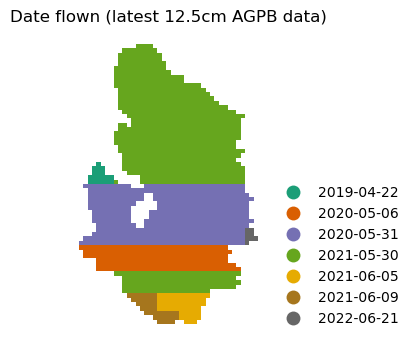

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
df_dateflown.plot(column='date', legend=True, ax=ax, 
                  legend_kwds={'loc': 'lower left', 'bbox_to_anchor': (1, 0), 'frameon': False},
                  cmap=plt.cm.get_cmap('Dark2', len(df_dateflown['date'].unique())))
ax.axis('off')
ax.set_title('Date flown (latest 12.5cm AGPB data)')